# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import roc_auc_score


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import variable_importance_df
from utilities import gridsearch_bias

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
tsetse_males_thorax = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'm') & (tsetse_data_copy['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'm') & (tsetse_data_copy['Tissue'] == 'Head')]

In [7]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [8]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [9]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

## Age prediction males

In [12]:
# Thorax

X_thorax_part1 = tsetse_males_thorax.loc[:,"4000":"402"]
X_thorax_part2 = tsetse_males_thorax.loc[:,"1800":"600"]
X_thorax_part3 = tsetse_males_thorax.loc[:,"3500":"2750"]
X_thorax_part4 = tsetse_males_thorax.loc[:,"2750":"1800"]

X_thorax_desbiased = pd.concat([X_thorax_part3,X_thorax_part2],axis=1)

y_thorax = tsetse_males_thorax.loc[:,"Age"]



In [14]:
# head

X_head_part1 = tsetse_males_head.loc[:,"4000":"402"]
X_head_part2 = tsetse_males_head.loc[:,"1800":"600"]
X_head_part3 = tsetse_males_head.loc[:,"3500":"2750"]
X_head_part4 = tsetse_males_head.loc[:,"2750":"1800"]

X_head_desbiased = pd.concat([X_head_part3,X_head_part2],axis=1)


y_head = tsetse_males_head.loc[:,"Age"]

In [15]:
# thorax
bias_test_part1 = gridsearch_bias(X_thorax_part1,y_thorax)
bias_test_part2 = gridsearch_bias(X_thorax_part2,y_thorax)
bias_test_part3 = gridsearch_bias(X_thorax_part3,y_thorax)
bias_test_part4 = gridsearch_bias(X_thorax_part4,y_thorax)
bias_test_part5 = gridsearch_bias(X_thorax_desbiased,y_thorax)

In [16]:
result = pd.concat([bias_test_part1, bias_test_part2['mean_test_score'],bias_test_part3['mean_test_score'],bias_test_part4['mean_test_score'],bias_test_part5['mean_test_score']], axis=1)
result["Tissue"] = "Thorax"
result

,param_clf,param_clf__kernel,mean_test_score,mean_test_score,mean_test_score,mean_test_score,mean_test_score,Tissue
0,SVM,rbf,0.716216,0.816216,0.600000,0.548649,0.783784,Thorax
1,SVM,linear,0.937838,0.883784,0.845946,0.937838,0.891892,Thorax
2,LR,NaN,0.891892,0.845946,0.797297,0.900000,0.843243,Thorax
3,RF,NaN,0.724324,0.751351,0.651351,0.583784,0.754054,Thorax


In [17]:
# head

bias_test_head_part1 = gridsearch_bias(X_head_part1, y_head)
bias_test_head_part2 = gridsearch_bias(X_head_part2, y_head)
bias_test_head_part3 = gridsearch_bias(X_head_part3, y_head)
bias_test_head_part4 = gridsearch_bias(X_head_part4, y_head)
bias_test_head_part5 = gridsearch_bias(X_head_desbiased, y_head)

In [18]:
result2 = pd.concat([bias_test_head_part1, 
    bias_test_head_part2['mean_test_score'],
    bias_test_head_part3['mean_test_score'],
    bias_test_head_part4['mean_test_score'],
    bias_test_head_part5['mean_test_score']], axis=1)

result2["Tissue"] = "Head"

In [19]:
bias_agemales = pd.concat([result2, result])
bias_agemales.set_index("Tissue", inplace=True)

bias_agemales.columns = ["Model", "kernel","D1","D2","D3","D4","D5"]
bias_agemales

bias_agemales.to_excel("../results/tables/wholespectra_results/biased_age_males_pred.xlsx")

In [20]:
# permutation test

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = LogisticRegression(max_iter=10000, random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_thorax, perm_scores_thorax, pvalue_thorax = permutation_test_score(
    clf, X_thorax_part1, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)

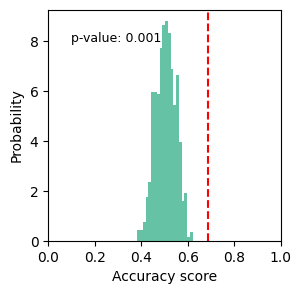

In [22]:
sn.set_palette('Set2')
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(perm_scores_thorax, bins=20, density=True)
ax.axvline(score_thorax, ls="--", color="r")
score_label = f"p-value: {pvalue_thorax:.3f}"
ax.text(0.1, 8, score_label, fontsize=9)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)

plt.savefig("../results/plots/permutationtest_age_males.png", dpi=300, bbox_inches='tight')

# Age prediction using the whole spectra

In [23]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax_part1, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head_part1, y_head, test_size=0.2, shuffle=True, random_state=123)

In [24]:
shape_data_classes = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "tsetse_thorax":y_th_test.value_counts()}

shape_data_classes_df = pd.DataFrame(shape_data_classes)
shape_data_classes_df
shape_data_classes_df.to_excel("../results/tables/wholespectra_results/train_test_shape_age_classes_males.xlsx")

In [25]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [26]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

In [27]:
output = data_plot_head.groupby(["param_clf"], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.616667  0.074120
1        LR  0.850000  0.059317
2        RF  0.730000  0.042889
3       SVC  0.733333  0.073703


In [28]:
output = data_plot_thorax.groupby(["param_clf"], as_index=False).agg({'value':['mean', 'std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.683333  0.072436
1        LR  0.883333  0.045134
2        RF  0.743333  0.081725
3       SVC  0.690000  0.070361


In [29]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)


Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [30]:
# thorax

best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [31]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [32]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.8947368421052632
Accuracy on test set: 0.918918918918919


In [33]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"

In [34]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Head"

In [35]:
report_age_males_prediction = pd.concat([report_head, report_thorax])

report_age_males_prediction.to_excel("../results/tables/wholespectra_results/Accuracy_age_males_report.xlsx")

In [36]:
# monte carlo cross validation
# head
accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head_part1, y_head, best_model_head)



shuffle split: 100%|██████████| 100/100 [00:12<00:00,  8.29it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.88 ± 0.06


In [37]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax_part1, y_thorax, best_mdoel_thorax)

shuffle split: 100%|██████████| 100/100 [00:09<00:00, 10.54it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.91 ± 0.05


In [38]:
monte_carlo = pd.DataFrame({"Accuracy": [np.mean(accuracy_head_mc),
                                         np.mean(accuracy_thorax_mc)], 
                            "std":[np.std(accuracy_head_mc),
                                   np.std(accuracy_thorax_mc)], 
                            "Sensitivity":[np.mean(sensitivity_head_mc),
                                           np.mean(sensitivity_thorax_mc)],
                            "std_s": [np.std(sensitivity_head_mc),
                                           np.std(sensitivity_thorax_mc)],
                            "Specificity": [np.mean(specificity_head_mc),
                                          np.mean(specificity_thorax_mc)],
                            "std_sp": [np.std(specificity_head_mc),
                                          np.std(specificity_thorax_mc)]}, index=['head','thorax'])

In [39]:
monte_carlo.to_excel("../results/tables/age_prediction_males_mc.xlsx")
monte_carlo

,Accuracy,std,Sensitivity,std_s,Specificity,std_sp
head,0.879211,0.062062,0.877575,0.090864,0.885520,0.086051
thorax,0.914324,0.051855,0.921526,0.065440,0.910812,0.074250


In [ ]:
waveNumslist = X_thorax_part1.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [31]:
top20_head = variable_importance_df(wavenumbers, best_model_head)
top20_thorax = variable_importance_df(wavenumbers, best_mdoel_thorax)

In [32]:
top20_thorax

,Wavenumbers,Coefficients
920,2160,1.745138
1039,1922,1.400018
919,2162,1.354854
890,2220,1.318110
889,2222,1.302505
990,2020,1.267557
978,2044,1.250347
891,2218,1.215197
921,2158,1.153436
1008,1984,1.136510


Text(1040, -2.260752, '1040')

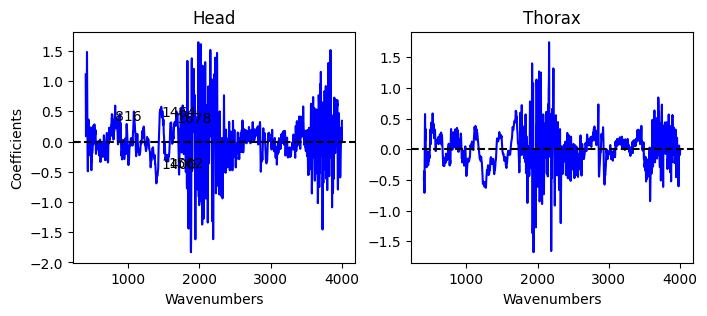

In [35]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),sharex=True)

sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)),color='k',alpha=0.5,ax=ax)
ax.axhline(y=0, color="k", ls="--")
#ax.set_xlim(1800,600)
ax.annotate('1464', xy=(1464,0.4214), xycoords='data',fontsize=10)
ax.annotate('1678', xy=(1678,0.3214), xycoords='data',fontsize=10)
ax.annotate('816', xy=(816,0.344), xycoords='data',fontsize=10)
ax.annotate('1400', xy=(1464,-0.45), xycoords='data',fontsize=10)
ax.annotate('1562', xy=(1562,-0.42), xycoords='data',fontsize=10)
ax.set_xlabel("Wavenumbers")
ax.set_ylabel("Coefficients")
ax.set_title("Head")


sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax2)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlabel("Wavenumbers")
ax2.set_title("Thorax")
ax2.annotate('782', xy=(782,3.59), xycoords='data',fontsize=10)
ax2.annotate('1750', xy=(1750,3.214), xycoords='data',fontsize=10)
ax2.annotate('1464', xy=(1464,3.44), xycoords='data',fontsize=10)
ax2.annotate('1692', xy=(1692, 2.785488), xycoords='data',fontsize=10)
ax2.annotate('772', xy=(772,-2.59), xycoords='data',fontsize=10)

ax2.annotate('686', xy=(686,	-2.576248), xycoords='data',fontsize=10)
ax2.annotate('1720', xy=(1720, -2.324863), xycoords='data',fontsize=10)

ax2.annotate('1040', xy=(1040,-2.260752), xycoords='data',fontsize=10)

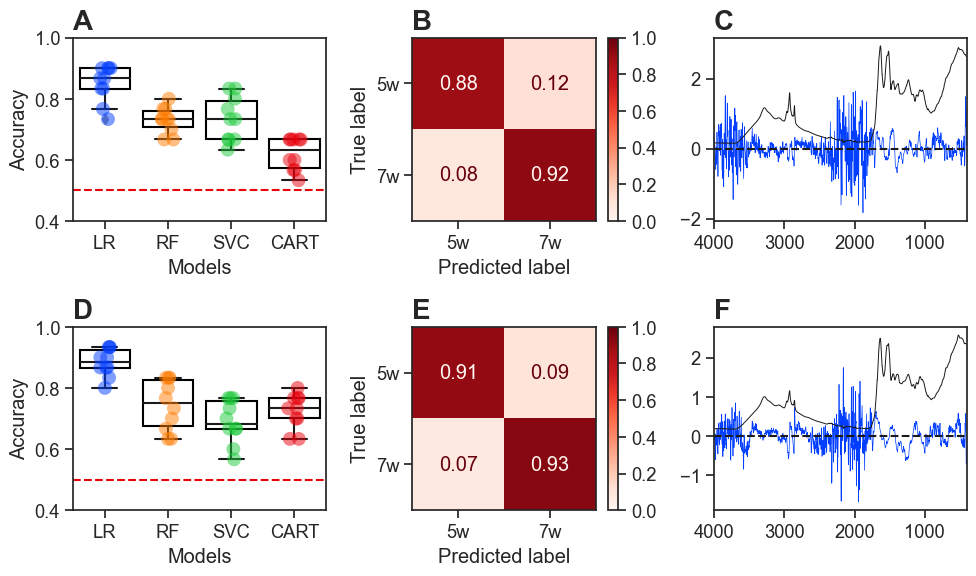

In [85]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,6), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax4, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax4, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax4.lines,color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor("black")
ax4.axhline(0.5, ls='--', color='r')
ax4.set_ylim(0.4,1)



plots1 = [ax,ax4]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax3, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax6, linewidth=0.5)
ax3.set_xlim(4000,402)
ax6.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax3, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax6, linewidth=0.7)

ax3.axhline(0, ls='--', color='k')
ax6.axhline(0, ls='--', color='k')

# confusion matrices
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0, 'vmax':1})

plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

for p, t in zip(plots1, letters):
    p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males.png", dpi=300)

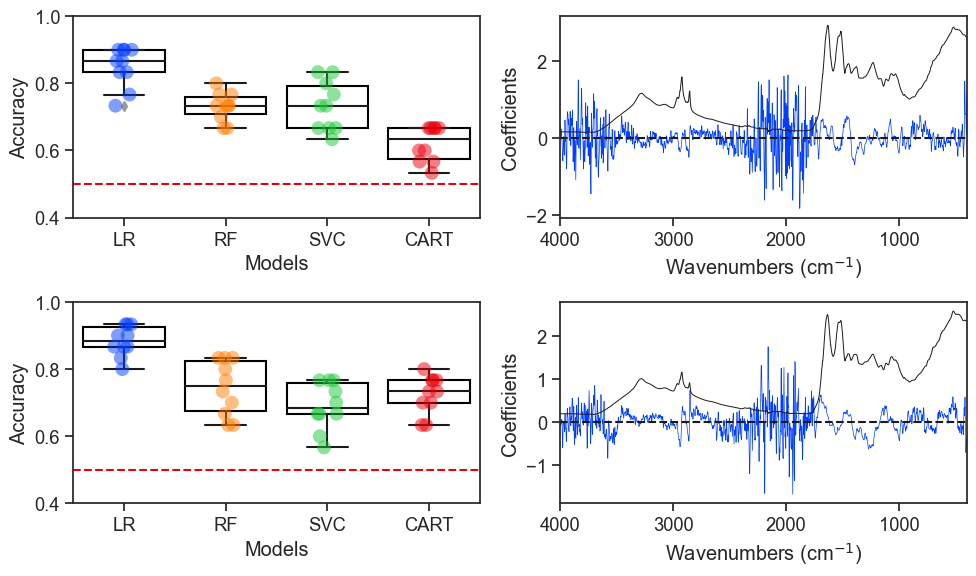

In [108]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax3.lines,color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor("black")
ax3.axhline(0.5, ls='--', color='r')
ax3.set_ylim(0.4,1)



plots1 = [ax,ax3]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

plots1 = [ax2,ax4]

for i in plots1:
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)
ax2.set_xlim(4000,402)
ax4.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax2, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax4, linewidth=0.7)

ax2.axhline(0, ls='--', color='k')
ax4.axhline(0, ls='--', color='k')


plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

#for p, t in zip(plots1, letters):
#    p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males.png", dpi=900)

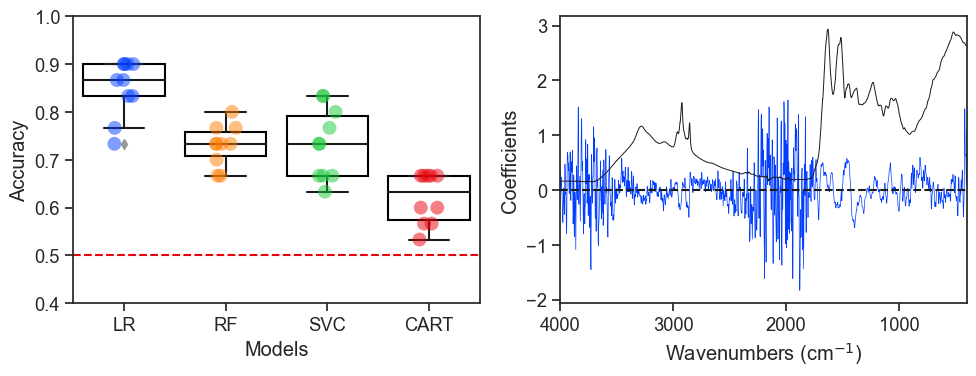

In [110]:
# Final plot age prediction males
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# boxplots
sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax, size=10,alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax.lines, color = 'k')
for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')
ax.axhline(0.5, ls="--", color='r')
ax.set_ylim(0.4,1)


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, color="white")
sn.stripplot(data=data_plot_thorax, x='param_clf', y='value', ax=ax3, size=10, alpha=0.5, hue='param_clf', legend=False)
plt.setp(ax3.lines,color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor("black")
ax3.axhline(0.5, ls='--', color='r')
ax3.set_ylim(0.4,1)



plots1 = [ax,ax3]

for i in plots1:
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

plots1 = [ax2,ax4]

for i in plots1:
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")
    i.set_ylabel("Coefficients")

# coefficients
sn.lineplot(x=wavenumbers,y=best_model_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)
sn.lineplot(x=wavenumbers,y=best_mdoel_thorax['model'].coef_[0], color='b',ax=ax4, linewidth=0.5)
ax2.set_xlim(4000,402)
ax4.set_xlim(4000,402)

sn.lineplot(x=wavenumbers, y = np.mean(X_head_part1, axis=0)*10, color='k', ax=ax2, linewidth=0.7)
sn.lineplot(x=wavenumbers, y = np.mean(X_thorax_part1, axis=0)*9, color='k', ax=ax4, linewidth=0.7)

ax2.axhline(0, ls='--', color='k')
ax4.axhline(0, ls='--', color='k')


plots1 = [ax,ax2,ax3,ax4,ax5,ax6]
letters = ["A", "B", "C", "D", "E", "F"]

#for p, t in zip(plots1, letters):
 #   p.set_title(t, loc="left", weight='bold', fontsize=20)

plt.savefig("../results/plots/age_prediction_males_v2.pdf", dpi=900)